<a href="https://colab.research.google.com/github/kscaman/MAP583/blob/main/TP/TP02_Full_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP02 - Cross entropy loss and handwritten character recognition
In this practical, we will first **re-implement the cross entropy loss**, and then write our first proper **training and testing pipeline** for a **handwritten character recognition task** (small version of the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset).

**FYI:** GPUs are not necessary for this practical.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


# Part A - Reimplementing loss functions

## A.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( softmax(s_i)_{y_i} \right)$$

where $softmax(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [22]:
### YOUR CODE HERE ###

n_batch = 4
n_classes = 10

X = torch.randn(n_batch, n_classes, device=device)
y = torch.randint(0, n_classes, [n_batch], device=device)

ce1 = nn.CrossEntropyLoss()
def ce2(input, target):
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss()
    return loss(m(input), target)

def ce3(input, target):
    m = nn.Softmax(dim=1)
    loss = nn.NLLLoss()
    return loss(np.log(m(input)), target)

loss1 = ce1(X, y)
loss2 = ce2(X, y)
loss3 = ce3(X, y)

print('loss1: %s' % loss1)
print('loss2: %s' % loss2)
print('loss3: %s' % loss3)

loss1: tensor(3.0779)
loss2: tensor(3.0779)
loss3: tensor(3.0779)


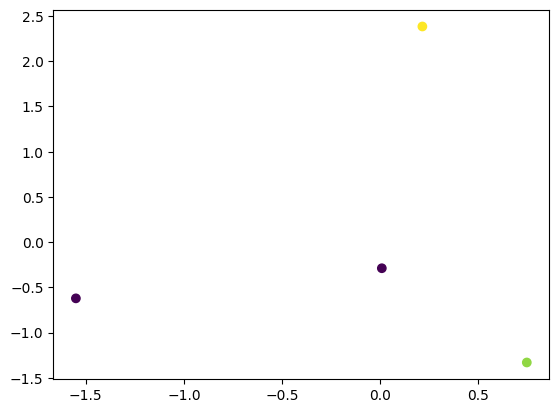

In [23]:
## vizualize the data
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu())

## A.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [24]:
### YOUR CODE HERE ###

def ce4(input, target):
    for i in range(len(input)):
        input[i] = torch.exp(input[i][target[i]]) / (torch.sum(torch.exp(input[i])))
    return -torch.mean(torch.log(input))


print('loss4: %s' % ce4(X, y))

loss4: tensor(3.0779)


## A.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [27]:
### YOUR CODE HERE ###

X = torch.randn(4, 10, device=device)*100
y = torch.randint(0, n_classes, [n_batch], device=device)

print('loss1: %s' % ce1(X, y))
print('loss2: %s' % ce2(X, y))
print('loss3: %s' % ce3(X, y))
print('loss4: %s' % ce4(X, y))

loss1: tensor(146.0404)
loss2: tensor(146.0404)
loss3: tensor(inf)
loss4: tensor(inf)


C:\Users\shito\AppData\Local\Temp\ipykernel_11516\2638945917.py:18: RuntimeWarning: divide by zero encountered in log
  return loss(np.log(m(input)), target)


Re-implement a stable version of cross-entropy.

In [ ]:
### YOUR CODE HERE ###

# Part B - Handwritten character recognition

## B.0 - Dataloader
Import `load_digits` from `sklearn.datasets` (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)), load the corresponding dataset and extract the images, data (i.e. flattened version of the images) and targets (i.e. the labels).

In [45]:
# import dataset
import sklearn.datasets
import pandas as pd

In [69]:
### YOUR CODE HERE ###
data = sklearn.datasets.load_digits()


Display the first image and its label.

<Figure size 640x480 with 0 Axes>

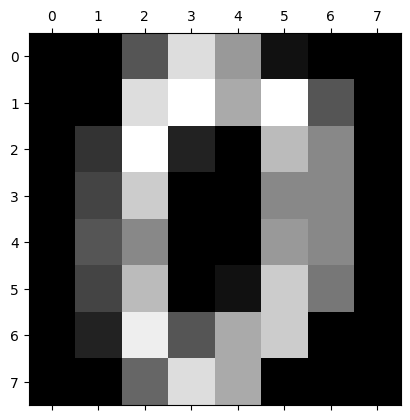

The label is: 0


In [70]:
### YOUR CODE HERE ###
plt.gray()
plt.matshow(data.images[0])
plt.show()

print("The label is:", data.target[0])

Then, create two PyTorch datasets and dataloaders with a batch size of $50$ for this task: one for the train (80% of the dataset) and one for the test (remaining 20% of the dataset).

In [135]:
### YOUR CODE HERE ###

# split the data into train and test using a data loader

from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(data.data, dtype=torch.float32)
y = torch.tensor(data.target, dtype=torch.long)
y = torch.nn.functional.one_hot(y, num_classes=10)

# converting y.dtype from long to float32
y = y.to(torch.float32)


dataset = TensorDataset(X, y)

# Splitting 80/20

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)


## B.1 - Model creation

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [136]:
### YOUR CODE HERE ###

class Model(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        self.width = width
        self.depth = depth
        self.layer1 = nn.Linear(64, width)
        self.layer2 = nn.Linear(width, 100)
        self.layer3 = nn.Linear(100, 10)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        return y

## B.2 - Loss and optimizer
Create a cross entropy loss.

In [137]:
### YOUR CODE HERE ###

loss = nn.CrossEntropyLoss()

## B.3 - Training and testing loops
Finally, create the functions `train(model, epoch)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [142]:
### YOUR CODE HERE ###


def train(model, epoch):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    step = 10**(-3)
    for e in range(epoch):
        model.zero_grad()
        for x, y in train_loader:
            output = model(x)
            #print(output.shape)
            l = loss(output, y)
            l.backward()
            optimizer.step()

        if e%10==0:
            # print test loss and accuracy
            correct = 0
            total = 0
            test_loss = 0
            for a,b in test_loader:
                output = model(a)
                test_loss += loss(output, b)
                _, predicted = torch.max(output.data, 1)
                total += b.size(0)
                correct += (predicted == torch.max(b, 1)[1]).sum().item()
            print('Epoch: %s' % e)
            print('Test Accuracy: %s' % (correct / total))
            print('Test Loss: %s' % test_loss.item())
            print('---------------------------')
            

                
                

Train your model for 200 epochs and display the test loss and accuracy every 10 epochs.

In [144]:
### YOUR CODE HERE ###
model = Model(100, 10)
model.to(device)

train(model, 200)

Epoch: 0
Test Accuracy: 0.7888888888888889
Test Loss: 3.4956252574920654
---------------------------
Epoch: 10
Test Accuracy: 0.9694444444444444
Test Loss: 0.8586376905441284
---------------------------
Epoch: 20
Test Accuracy: 0.9777777777777777
Test Loss: 0.5952854752540588
---------------------------
Epoch: 30
Test Accuracy: 0.9722222222222222
Test Loss: 0.5891249179840088
---------------------------
Epoch: 40
Test Accuracy: 0.9666666666666667
Test Loss: 0.4935830235481262
---------------------------
Epoch: 50
Test Accuracy: 0.9611111111111111
Test Loss: 0.6273609399795532
---------------------------
Epoch: 60
Test Accuracy: 0.975
Test Loss: 0.3819238245487213
---------------------------
Epoch: 70
Test Accuracy: 0.9833333333333333
Test Loss: 0.3417891263961792
---------------------------
Epoch: 80
Test Accuracy: 0.9805555555555555
Test Loss: 0.37074336409568787
---------------------------
Epoch: 90
Test Accuracy: 0.9861111111111112
Test Loss: 0.32745370268821716
--------------------

## B.4 - Analyze the results

Create a confusion matrix on the train and test datasets using `ConfusionMatrixDisplay.from_predictions` from `sklearn.metrics`. Which digits are confused?

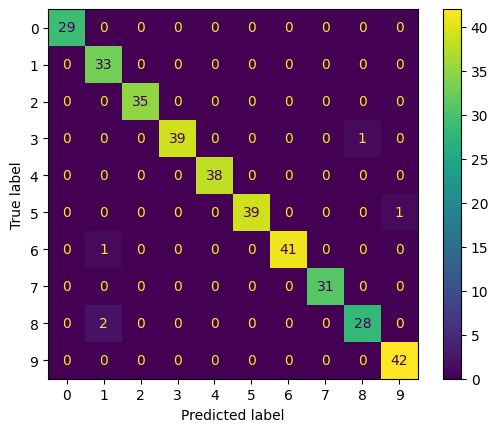

In [146]:
### YOUR CODE HERE ###

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(model):
    y_pred = []
    y_true = []
    for x, y in test_loader:
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        y_pred.append(predicted)
        y_true.append(torch.max(y, 1)[1])
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot()
    plt.show()

plot_confusion_matrix(model)

## B.5 - PCA and TSNE visualizations (optional)

To check wether the problem is easily to solve, plot the PCA and TSNE visualization of the dataset, where each digit corresponds to a different color. Are the digits/classes well separated?

In [149]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

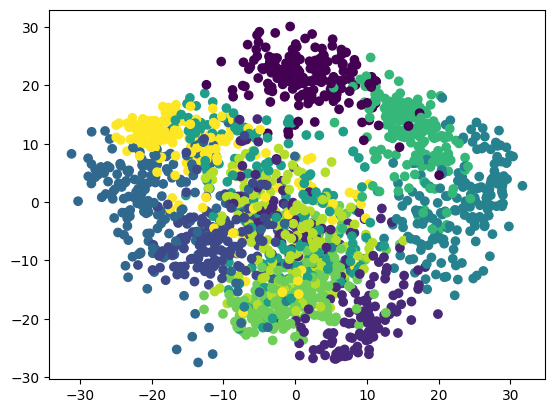

In [153]:
### YOUR CODE HERE ###

def pca_vizualisation(X,y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap = "viridis")
    plt.show()

pca_vizualisation(data.data, data.target)

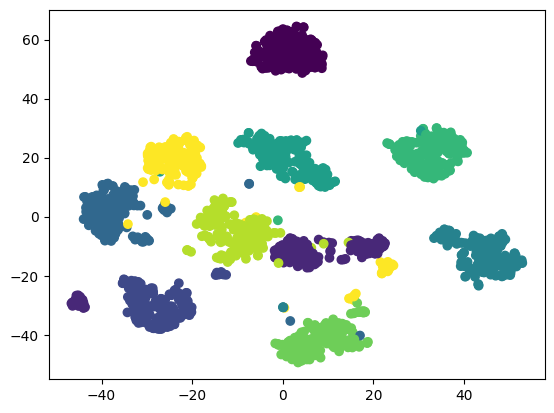

In [154]:
def tsne_vizualisation(X,y):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap = "viridis")
    plt.show()

tsne_vizualisation(data.data, data.target)

## B.6 - Model complexity (optional)
How many parameters does the model have? Are they necessary? Try different architectures, including a linear model (use `bias=False` in `nn.Linear` to remove the bias term).

In [ ]:
### YOUR CODE HERE ###